## conda environments

When accessing this notebook via the JASMIN Jupyter Notebook service, select the correct conda environment from the list of available kernels.

## Imports

In [1]:
from os import path
import pandas as pd
import matplotlib.pyplot as plt
from data_classes import HealthData
from ONS_Excel import weekly_urls, weekly_sheet_names, weekly_row_indices

## Code

### Weekly mortality
Weekly data across England & Wales; by age, sex, region. Processed to look specifically at London region (all ages, all sexes).

In [ ]:
home_folder = path.join(path.abspath(""), "mortality_data")

#### Download & process the mortality data

Perks of using Excel files from the Office for National Statistics...

In [ ]:
urls = weekly_urls
sheet_names = weekly_sheet_names
row_indices = weekly_row_indices

In [ ]:
mortality_df = pd.DataFrame()

for year in range(2010, 2022):
    mortality_annual = HealthData(home_folder, url=urls[year])
    mortality_annual.download(verbose=False)
    df = mortality_annual.read_xls(sheet_names[year], verbose=False)
    rows = row_indices[year]
    annual_df = df.loc[rows]
    annual_df = annual_df.T.dropna().rename(columns={rows[0]:"date", rows[1]:"weekly_deaths"}).reset_index(drop=True).drop([0]).set_index("date")
    annual_df.index = pd.to_datetime(annual_df.index)
    if mortality_df.empty:
        mortality_df = annual_df.copy()
    else:
        mortality_df = mortality_df.append(annual_df.copy())
    print(f"{year} done...")
    
mortality_df.to_csv(path.join(home_folder, "weekly_mortality_London.csv"))

#### Load the processed data from .csv file

In [ ]:
mortality_annual = HealthData(home_folder, filename="weekly_mortality_London.csv")
mortality_df = mortality_annual.read_csv()
mortality_df.sample(5)

#### Plot the dataframe

In [ ]:
mortality_df.plot(legend=False, title="London").set_ylabel("weekly deaths")
plt.show()

### Daily mortality
Daily mortality data at regional scale. Here we select for the Greater London region using region code E12000007.

In [7]:
home_folder = path.join(path.abspath(""), "mortality_data/daily")
region_code = "E12000007"
start_year = 1981
end_year = 2018

In [8]:
urls = {}
urls.update(dict.fromkeys(list(range(1981, 2014+1)), "https://www.ons.gov.uk/file?uri=/peoplepopulationandcommunity/birthsdeathsandmarriages/deaths/adhocs/005459dailydeathoccurrencesenglandregionsofenglandandwales1970to2014/dailydeathoccurrences19702014.zip"))
urls.update(dict.fromkeys(list(range(2013, 2017+1)), "https://www.ons.gov.uk/file?uri=/peoplepopulationandcommunity/birthsdeathsandmarriages/deaths/adhocs/009728dailydeathoccurrencesregionsofenglandandwales2013to2016/dailydeathoccurrences20132017.xls"))
urls.update(dict.fromkeys(list(range(2015, 2018+1)), "https://www.ons.gov.uk/file?uri=/peoplepopulationandcommunity/birthsdeathsandmarriages/deaths/adhocs/11189dailydeathsenglishregionsandwales2015to2018occurrences/dailydeathsfinal.xlsx"))

In [9]:
daily_df = pd.DataFrame()

for year in range(start_year, end_year+1):
    url = urls[year]
    
    if year == start_year or not url == urls[year-1]:
        mortality = HealthData(home_folder, url)
        if not path.exists(mortality.filepath):
            mortality.download(verbose=False)
        if mortality.extension == ".zip":
            mortality.unzip(mortality.zipfiles[0], verbose=False)
        daily_adhoc_df = mortality.read_xls(mortality.sheets[-1], verbose=False)
        daily_adhoc_df.columns = range(daily_adhoc_df.shape[1])
        daily_adhoc_df = daily_adhoc_df.loc[daily_adhoc_df[3] == region_code, [0, 1, 2, 3, 4]]
        daily_adhoc_df.columns = ["year", "month", "day", "region_code", "deaths"]
        daily_adhoc_df["date"] = pd.to_datetime(daily_adhoc_df[["year", "month", "day"]])
    
    daily_df = daily_df.append(daily_adhoc_df.loc[daily_adhoc_df["year"] == year, ["date", "deaths"]].copy().set_index("date"))

print(daily_df.shape)

(13879, 1)


In [12]:
daily_df.to_csv(path.join(home_folder, "daily_mortality_London.csv"))

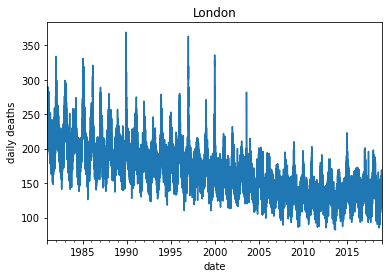

In [11]:
daily_df.plot(legend=False, title="London").set_ylabel("daily deaths")
plt.show()

### Population data

In [ ]:
home_folder = path.join(path.abspath(""), "population_data")

#### Download & process the population data

In [ ]:
url = "https://www.ons.gov.uk/file?uri=/peoplepopulationandcommunity/populationandmigration/populationestimates/datasets/populationestimatesforukenglandandwalesscotlandandnorthernireland/mid2001tomid2019detailedtimeseries/regionalpopestimatesforenglandandwales19712019.xlsx"
pop_data = HealthData(home_folder, url=url)
pop_data.download()

In [ ]:
population_df = pd.DataFrame()

for sheet in ["Table 3", "Table 4"]:
    df = pop_data.read_xls(sheet, verbose=False)
    df = df.loc[df[0].apply(lambda x: isinstance(x, int))].reset_index(drop=True)[[0]].rename(columns={0:"date"}).join(df.loc[df[1]=="London"].reset_index(drop=True)[[2]].rename(columns={2:"total_population"})).set_index("date")
    df.index = pd.to_datetime(df.index, format="%Y") + pd.tseries.offsets.DateOffset(months=6) # Set these as mid-year estimates
    if population_df.empty:
        population_df = df.copy()
    else:
        population_df = population_df.append(df.copy())
        
population_df.to_csv(path.join(home_folder, "annual_population_London.csv"))

#### Load the processed data from .csv file

In [ ]:
pop_data = HealthData(home_folder, filename="annual_population_London.csv")
population_df = pop_data.read_csv(index_col="date")
population_df.sample(3)

#### Plot the dataframe

In [ ]:
population_df.plot(legend=False, title="London").set_ylabel("annual population")
plt.show()

#### Interpolation of annual data

In [ ]:
step_df = population_df.resample("D").asfreq().fillna(method="ffill")
linear_df = population_df.resample("D").asfreq().interpolate(method="linear")

In [ ]:
step_df.plot(legend=False, title="London annual population (mid-year step change)").set_ylabel("population")
linear_df.plot(legend=False, title="London daily population (interpolation)").set_ylabel("population")
plt.show()

### Calculating deaths as a fraction of population

In [ ]:
df = linear_df.join(mortality_df).dropna()
df["deaths_per_capita"] = df["weekly_deaths"]/df["total_population"]
df["deaths_per_capita"].plot(legend=False, title="London weekly deaths").set_ylabel("mortality per capita")
plt.show()

In [ ]:
df.to_csv(path.join(path.join(path.abspath(""), "mortality_data"), "weekly_mortality_percapita_London.csv"))